# EMD Thermal Conductivity
This example is originally from [GPUMD](https://github.com/brucefan1983/GPUMD) and has been added here with minor changes only to demonstrate how to use [gpyumd](https://github.com/AlexGabourie/gpyumd).

## 1. Introduction
- In this example, we use the EMD (Green-Kubo) method to calculate the lattice thermal conductivity of graphene at 300 K and zero pressure.

### Importing Relevant Functions
- The inputs/outputs for GPUMD are processed using the [Atomic Simulation Environment (ASE)](https://wiki.fysik.dtu.dk/ase/) and the [gpyumd](https://github.com/AlexGabourie/gpyumd) package.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from ase.build import graphene_nanoribbon
from gpyumd.load import load_hac
from gpyumd.atoms import GpumdAtoms
from gpyumd.sim import Simulation
import gpyumd.keyword as kwd

## 2. Preparing the Inputs
- The [xyz.in](https://gpumd.zheyongfan.org/index.php/The_xyz.in_input_file)  file used is the same as in density of states tutorial.
- We use a Tersoff potential [[Tersoff 1989]](https://doi.org/10.1103/PhysRevB.39.5566) parameterized by Lindsay *et al.* [[Lindsay 2010]](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.81.205441).
- Note that the thickness of the graphene sheet is set to 3.35 $\mathring A$ according to the convention in the literature. This thickness is needed to calculate an effective 3D thermal conductivity for a 2D material.

### The  [xyz.in](https://gpumd.zheyongfan.org/index.php/The_xyz.in_input_file) file

In [2]:
gnr = GpumdAtoms(graphene_nanoribbon(60, 36, type='armchair', sheet=True, vacuum=3.35/2, C_C=1.44))
gnr.euler_rotate(theta=90)
lx, lz, ly = gnr.cell.lengths()
gnr.cell = gnr.cell.new((lx, ly, lz))
gnr.center()
gnr.pbc = [True, True, False]
gnr.set_cutoff(2.1)
gnr.set_max_neighbors(3)
gnr.write_gpumd()
gnr

GpumdAtoms(symbols='C8640', pbc=[True, True, False], cell=[149.64918977395098, 155.52, 3.35])

- The first few lines of the [xyz.in](https://gpumd.zheyongfan.org/index.php/The_xyz.in_input_file) file are:
```
8640 3 2.1 0 0 0
1 1 0 149.649 155.52 3.35
0 1.24708 0 0 12
0 0 0.72 0 12
0 0 2.16 0 12
0 1.24708 2.88 0 12
```

- Explanations for the first line:
  - The first number states that the number of particles is 8640.
  - The second number in this line, 3, is good for graphene described by the Tersoff potential because no atom can have more than 3 neighbor atoms at room temperature. Making this number larger only results in more memory usage. If this number is not large enough, GPUMD will give an error message and exit.
  - The next number, 2.1, means that the initial cutoff distance for the neighbor list construction is 2.1 A. Here, we only need to consider the first nearest neighbors. Any number larger than the first nearest neighbor distance and smaller than the second nearest neighbor distance is OK here. Note that we will also not update the neighbor list. There is no such need in this problem. 
  - The remaining three zeros in the first line mean:
    - the box is orthogonal;
    - the initial velocities are not contained in this file;
    - there are no grouping methods defined here.


 - Explanations for the second line:
   - The numbers 1 1 0 mean that the x and y (in-plane) directions are periodic and the z direction is open (free).
   - The remaining three numbers are the box lengths in the three directions. The box length in a free direction is chosen based on some convention. This number will only affect the system volume.

- Starting from the third line, the numbers in the first column are all 0 here, which means that all the atoms are of type 0 (single atom-type system). The next three columns are the initial coordinates of the atoms. The last column gives the masses of the atoms. Here, we consider isotopically pure C-12 crystal, but this Jupyter notebook will generate an [xyz.in](https://gpumd.zheyongfan.org/index.php/The_xyz.in_input_file) file using the average of the various isotopes of C. In some applications, one can consider mass disorder in a flexible way.

Note: We write the <code>xyz.in</code> file here for demonstration purposes, but the Simulation we are about to make also outputs the <code>xyz.in</code> file.

### The <code>run.in</code> file
The [gpyumd](https://github.com/AlexGabourie/gpyumd) package can be used to generate valid <code>run.in</code> input files as well as other necessary input files. It follows the definitions described in the [inputs and outputs](https://gpumd.zheyongfan.org/index.php/Main_Page#Inputs_and_outputs_for_GPUMD) documentation for <code>GPUMD</code>.

In [3]:
emd_sim = Simulation(gnr, driver_directory='.')

In [4]:
# Equilibration run
header_comment = "Equilibration"
curr_run = emd_sim.add_run(number_of_steps=1e6, run_name='equilibration', run_header=header_comment)

# Create ensemble for the equilibration
npt_condition = 'orthogonal'
pdict = kwd.Ensemble.get_npt_pdict(condition=npt_condition)
pdict['p_xx'], pdict['p_yy'], pdict['p_zz'] = [0]*3  # GPa
pdict['C_xx'], pdict['C_yy'], pdict['C_zz'] = [53.4059]*3  # GPa

npt_ensemble = kwd.Ensemble(ensemble_method='npt_ber')
npt_ensemble.set_npt_parameters(initial_temperature=300, final_temperature=300, thermostat_coupling=100, 
                                barostat_coupling=2000, condition=npt_condition, pdict=pdict)

keywords = [
    kwd.Velocity(initial_temperature=300),
    npt_ensemble,
    kwd.TimeStep(dt_in_fs=1),
    kwd.NeighborOff(),
    kwd.DumpThermo(1000)
]

for keyword in keywords:
    curr_run.add_keyword(keyword)

In [5]:
curr_run

Run: 'equilibration'
# Equilibration
  Velocity(initial_temperature=300)
  Ensemble(npt_ber=NPT(initial_temperature=300, final_temperature=300, thermostat_coupling=100, barostat_coupling=2000, condition=orthogonal, pdict=...))
  TimeStep(dt_in_fs=1, max_distance_per_step=None)
  NeighborOff()
  DumpThermo(interval=1000)
run 1000000 steps, dt_in_fs=1 -> 1.0 ns


In [6]:
# Production run
header_comment = "Production"
curr_run = emd_sim.add_run(run_name='production', run_header=header_comment)

# Timestep is propagated from last run
keywords = [
    kwd.Ensemble(ensemble_method='nve'),
    kwd.NeighborOff(),
    kwd.ComputeHAC(sample_interval=20, num_corr_steps=50000, output_interval=10),
    kwd.RunKeyword(number_of_steps=1e7)  # Can add run here instead of during add_run fucntion
]

for keyword in keywords:
    curr_run.add_keyword(keyword)

In [7]:
potential_directory = "/path/to/GPUMD/potentials/tersoff"
tersoff_potential = \
    kwd.Potential(filename='Graphene_Lindsay_2010_modified.txt', symbols=['C'], directory=potential_directory)
emd_sim.add_potential(tersoff_potential)

In [8]:
emd_sim.create_simulation(copy_potentials=True)

The <code>run.in</code> input file is given below:<br>
```
potential Graphene_Lindsay_2010_modified.txt 0

# Equilibration
time_step 1 
velocity 300 
ensemble npt_ber 300 300 100 0 0 0 53.4059 53.4059 53.4059 2000 
neighbor off 
dump_thermo 1000 
run 1000000 

# Production
ensemble nve 
neighbor off 
compute_hac 20 50000 10 
run 10000000 

```
- The first line uses the [potential](https://gpumd.zheyongfan.org/index.php/The_potential_keyword) keyword to define the potential to be used, which is specified in the file [Graphene_Lindsay_2010_modified.txt](https://github.com/brucefan1983/GPUMD/blob/master/potentials/tersoff/Graphene_Lindsay_2010_modified.txt).

- The second line uses the [velocity](https://gpumd.zheyongfan.org/index.php/The_velocity_keyword) keyword and sets the velocities to be initialized with a temperature of 300 K. 

- There are two runs.
  - The first [run](https://gpumd.zheyongfan.org/index.php/The_run_keyword) serves as the equilibration stage, where the NPT [ensemble](https://gpumd.zheyongfan.org/index.php/The_ensemble_keyword) (the Berendsen barostat) is used. The temperature is 300 K and the pressures are zero in all the directions. The coupling constants are 100 and 2000 time steps for the thermostat and the barostat (The elastic constant, or inverse compressibility parameter needed in the barostat is estimated to be 53.4059 GPa; this only needs to be correct up to the order of magnitude.), respectively. The [time_step](https://gpumd.zheyongfan.org/index.php/The_time_step_keyword) for integration is 1 fs. There are $10^6$ steps (1 ns) for this [run](https://gpumd.zheyongfan.org/index.php/The_run_keyword) and the thermodynamic quantities will be output every 1000 steps.
  - The second [run](https://gpumd.zheyongfan.org/index.php/The_run_keyword) is for production. Here, the NVE [ensemble](https://gpumd.zheyongfan.org/index.php/The_ensemble_keyword) is used. The line with the [compute_hac](https://gpumd.zheyongfan.org/index.php/The_compute_hac_keyword) keyword means that heat currents will be recorded every 20 steps (20 fs), 50000 HAC data (the maximum correlation time is then about 1 ns) will be calculated, and the HAC are averaged for every 10 data points before written out. The production time is 10 ns ($10^7$ steps), which is 10 times as long as the maximum correlation time. This is a reasonable choice.

## 3. Results and Discussion
### Computation Time
- The results below are from three independent runs, which took about two hours in total using a Tesla K40 card or 30 minutes using a Tesla V100 card.

### Figure Properties

In [9]:
aw = 2
fs = 16
font = {'size'   : fs}
plt.rc('font', **font)
plt.rc('axes' , linewidth=aw)

def set_fig_properties(ax_list):
    ax_list = ax_list if isinstance(ax_list, list) else [ax_list]
    tl = 8
    tw = 2
    tlm = 4
    
    for ax in ax_list:
        ax.tick_params(which='major', length=tl, width=tw)
        ax.tick_params(which='minor', length=tlm, width=tw)
        ax.tick_params(which='both', axis='both', direction='in', right=True, top=True)

### Plot HAC (heat current autocorrelations) & RTC (running thermal conductivity)
 - The [hac.out](https://gpumd.zheyongfan.org/index.php/The_hac.out_output_file) output file is loaded and processed to create the following figure.

In [10]:
hac = load_hac([50000]*3, [10]*3)
print("Runs:", list(hac.keys()))
print("Run Data:", list(hac['run0'].keys()))

Runs: ['run0', 'run1', 'run2']
Run Data: ['t', 'jxijx', 'jxojx', 'jyijy', 'jyojy', 'jzjz', 'kxi', 'kxo', 'kyi', 'kyo', 'kz']


In [11]:
t = hac['run0']['t']
hac_ave_i = np.zeros(hac['run0']['jxijx'].shape[0])
hac_ave_o = np.zeros_like(hac_ave_i)
ki_ave, ko_ave = np.zeros_like(hac_ave_i), np.zeros_like(hac_ave_o)
for runkey in hac.keys():
    hac_ave_i += hac[runkey]['jxijx']+hac[runkey]['jyijy']
    hac_ave_o += hac[runkey]['jxojx']+hac[runkey]['jyojy']
    ki_ave += (hac[runkey]['kxi']+hac[runkey]['kyi'])
    ko_ave += (hac[runkey]['kxo']+hac[runkey]['kyo'])
hac_ave_i /= hac_ave_i.max()
hac_ave_o /= hac_ave_o.max()
ki_ave /= 6.
ko_ave /= 6.

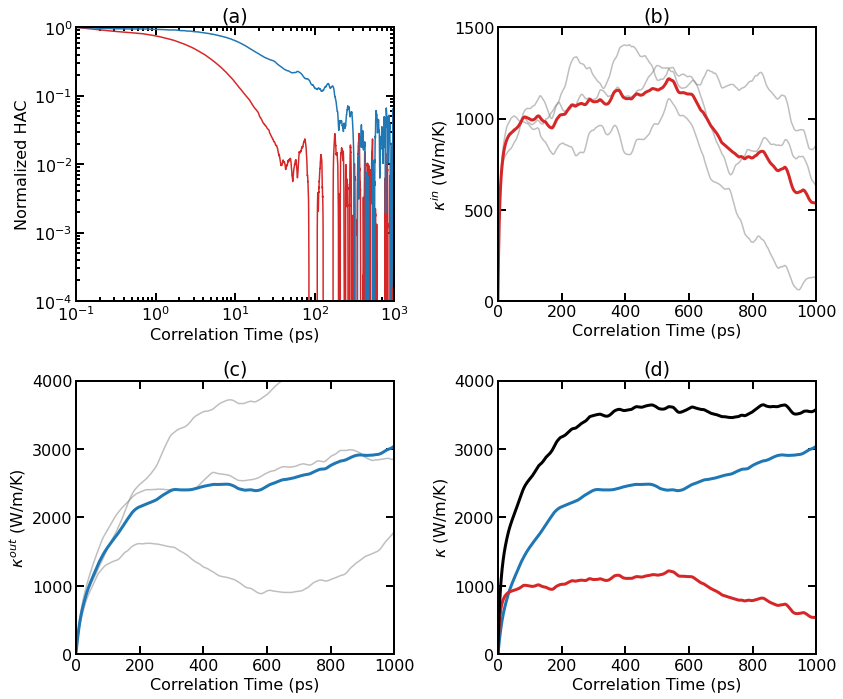

In [12]:
axes = list()
plt.figure(figsize=(12,10))
plt.subplot(2,2,1)
axes.append(plt.gca())
plt.loglog(t, hac_ave_i, color='C3')
plt.loglog(t, hac_ave_o, color='C0')
plt.xlim([1e-1, 1e3])
plt.ylim([1e-4, 1])
plt.xlabel('Correlation Time (ps)')
plt.ylabel('Normalized HAC')
plt.title('(a)')

plt.subplot(2,2,2)
axes.append(plt.gca())
for runkey in hac.keys():
    plt.plot(hac[runkey]['t'], (hac[runkey]['kxi']+hac[runkey]['kyi'])/2, color='C7',alpha=0.5)
plt.plot(t, ki_ave, color='C3', linewidth=3)
plt.xlim([0, 1000])
plt.gca().set_xticks(range(0,1001,200))
plt.ylim([0, 1500])
plt.gca().set_yticks(range(0,1501,500))
plt.xlabel('Correlation Time (ps)')
plt.ylabel(r'$\kappa^{in}$ (W/m/K)')
plt.title('(b)')

plt.subplot(2,2,3)
axes.append(plt.gca())
for runkey in hac.keys():
    plt.plot(hac[runkey]['t'], (hac[runkey]['kxo']+hac[runkey]['kyo'])/2, color='C7',alpha=0.5)
plt.plot(t, ko_ave, color='C0', linewidth=3)
plt.xlim([0, 1000])
plt.gca().set_xticks(range(0,1001,200))
plt.ylim([0, 1500])
plt.gca().set_yticks(range(0,4001,1000))
plt.xlabel('Correlation Time (ps)')
plt.ylabel(r'$\kappa^{out}$ (W/m/K)')
plt.title('(c)')

plt.subplot(2,2,4)
axes.append(plt.gca())
plt.plot(t, ko_ave, color='C0', linewidth=3)
plt.plot(t, ki_ave, color='C3', linewidth=3)
plt.plot(t, ki_ave + ko_ave, color='k', linewidth=3)
plt.xlim([0, 1000])
plt.gca().set_xticks(range(0,1001,200))
plt.ylim([0, 1500])
plt.gca().set_yticks(range(0,4001,1000))
plt.xlabel('Correlation Time (ps)')
plt.ylabel(r'$\kappa$ (W/m/K)')
plt.title('(d)')

set_fig_properties(axes)
plt.tight_layout()
plt.show()

Thermal conductivity results for pristine graphene at 300 K from EMD simulations. **(a)** Normalized HAC as a function of correlation time for the in-plane and out-of-plane components. **(b)** Individual (thin lines) and averaged (thick line) RTC as a function of correlation time for the in-plane component. **(c)** Individual (thin lines) and averaged (thick line) RTC as a function of correlation time for the out-of-plane component. **(d)** Averaged RTC as a function of correlation time for various components.

### Results
- As the system is essentially isotropic in the planar directions, we only consider a scalar thermal conductivity $\kappa=(\kappa_{xx}+\kappa_{yy})/2$ for the 2D system. However, we consider the *in-out decomposition* as introduced in [[Fan 2017]](https://doi.org/10.1103/PhysRevB.95.144309).
- From **(a)**, we can see that the in-plane component and the out-of-plane component of the HAC have different time scales. The latter decays much more slowly. 
- Panel **(b)** shows the individual and averaged RTCs for the in-plane component $\kappa^{\rm in}(t)$. The averaged RTC converges to about 1000 W/m/K at around 100 ps. 
- Panel **(c)** shows the individual and averaged RTCs for the out-of-plane component $\kappa^{\rm out}(t)$, and the convergence property is not very clear here. This is because the out-of-plane component converges very slowly and three independent simulations (each with 10 ns) are not enough to give accurate results. 
- Summing up $\kappa^{\rm in}(t)$ and $\kappa^{\rm out}(t)$, we get $\kappa^{\rm tot}(t)$, as shown in panel **(d)**.

## 4. References
- [Fan 2017] Zheyong Fan, Luiz Felipe C. Pereira, Petri Hirvonen, Mikko M. Ervasti, Ken R. Elder, Davide Donadio, Tapio Ala-Nissila, and Ari Harju, [Thermal conductivity decomposition in two-dimensional materials: Application to graphene](https://doi.org/10.1103/PhysRevB.95.144309), Phys. Rev. B **95**, 144309 (2017).
- [Lindsay 2010] L. Lindsay and D.A. Broido, [Optimized Tersoff and Brenner emperical potential parameters for lattice dynamics and phonon thermal transport in carbon nanotubes and graphene](https://doi.org/10.1103/PhysRevB.39.5566), Phys. Rev. B, **81**, 205441 (2010).
- [Tersoff 1989] J. Tersoff, [Modeling solid-state chemistry: Interatomic potentials for multicomponent systems](https://doi.org/10.1103/PhysRevB.39.5566), Phys. Rev. B 39, 5566(R) (1989).